# Template for analyzing the CLM5-PPE
- Updated Aug 22, 2023
- Daniel Kennedy, djk2120@ucar.edu and Katie Dagon, kdagon@ucar.edu

## Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cftime

In [2]:
# import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

## Load the CLM-PPE
Reduced data version: annual, biome means for 1850-2014, 500 ensemble members plus the default parameters.\
Using [xarray](https://docs.xarray.dev/en/stable/index.html) to read in netcdf file.

In [3]:
file = '/glade/u/home/djk2120/ppe_clean/postp/lhc/ccycle.ann.LHC.nc'
ds = xr.open_dataset(file)

In [4]:
ds

<xarray.Dataset>
Dimensions:         (biome: 11, year: 165, ens: 501)
Coordinates:
  * biome           (biome) object 'Global' 'Ice sheet' ... 'Tundra'
  * year            (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
Dimensions without coordinates: ens
Data variables: (12/23)
    TOTVEGC         (ens, year, biome) float64 ...
    TOTECOSYSC      (ens, year, biome) float64 ...
    TOTSOMC         (ens, year, biome) float64 ...
    TOTSOMC_1m      (ens, year, biome) float64 ...
    TLAI            (ens, year, biome) float64 ...
    GPP             (ens, year, biome) float64 ...
    ...              ...
    FCEV            (ens, year, biome) float64 ...
    EFLX_LH_TOT     (ens, year, biome) float64 ...
    NPP_NUPTAKE     (ens, year, biome) float64 ...
    TOTVEGN         (ens, year, biome) float64 ...
    TOTSOMN         (ens, year, biome) float64 ...
    TOTSOMN_1m      (ens, year, biome) float64 ...
Attributes:
    orig:     /glade/campaign/asp/djk2120/PPEn11/transient/hist/PPEn11_transi...
    key:      LHC0000
    lafile:   /glade/u/home/djk2120/ppe_clean/pyth/sparsegrid_landarea.nc
    bfile:    /glade/u/home/djk2120/ppe_clean/pyth/whit/whitkey.nc
    history:  Tue Jun  6 16:02:38 2023: ncecat -u ens LHC0000.nc LHC0001.nc L...
    NCO:      netCDF Operators version 5.1.4 (Homepage = http://nco.sf.net, C...

### Look at a specific variable timeseries

In [7]:
# TLAI = total leaf area index (we selected parameters based on sensitivity to this variable)
ds['TLAI']

<xarray.DataArray 'TLAI' (ens: 501, year: 165, biome: 11)>
[909315 values with dtype=float64]
Coordinates:
  * biome    (biome) object 'Global' 'Ice sheet' ... 'Boreal forest' 'Tundra'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
Dimensions without coordinates: ens
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean year: mean

### Plot a single timeseries
Leverage xarray's [built-in plotting](https://docs.xarray.dev/en/latest/user-guide/plotting.html) functionality

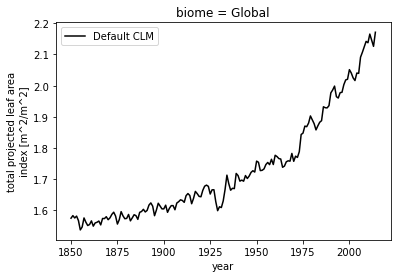

In [42]:
# global mean TLAI for the first ensemble member (default parameters)
ds['TLAI'].sel(ens=0, biome='Global').plot(color='k',label='Default CLM')
plt.legend();

### Plot all the ensemble members

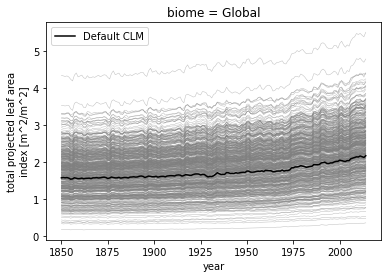

In [43]:
# add the ensemble members
for i in range(len(ds.ens)-1):
    # ensemble members 1-500 (skipping default member 0)
    var = ds['TLAI'].sel(biome='Global',ens=i+1)
    var.plot(color='grey',linewidth=0.5,alpha=0.5)

# plot the default as a black line
ds['TLAI'].sel(ens=0, biome='Global').plot(color='k',label='Default CLM')
plt.legend();

### Plot a histogram of global, annual mean values
Here use [matplotlib](https://matplotlib.org/) instead of xarray's built in plotting to make a more custom plot

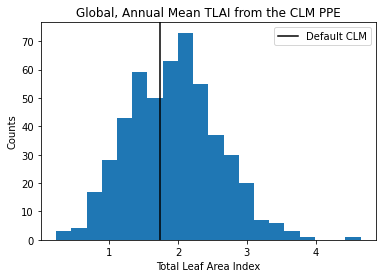

In [33]:
# ensemble members 1-500 (skipping default member 0)
plt.hist(ds['TLAI'].sel(ens=slice(1,len(ds.ens)),biome='Global').mean(dim='year'), bins=20)
plt.xlabel('Total Leaf Area Index')
plt.ylabel('Counts')
plt.title('Global, Annual Mean TLAI from the CLM PPE')

# plot the default as a vertical black line
plt.axvline(ds['TLAI'].sel(ens=0,biome='Global').mean(dim='year'), color='k', label='Default CLM')
plt.legend();

### Load the parameter sets 
These are normalized parameter values based on [0,1] for min/max values.\
LHC = latin hypercube (the sampling method for the PPE)

In [40]:
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt' # note: this table does not include the default parameters
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [22]:
ppe_params

,FUN_fracfixers,KCN,a_fix,crit_dayl,d_max,fff,froot_leaf,fstor2tran,grperc,jmaxb0,...,psi50,q10_mr,slatop,soilpsi_off,stem_leaf,sucsat_sf,theta_cj,tpu25ratio,tpuse_sf,wc2wjb0
0,0.778311,0.358026,0.255021,0.401235,0.797847,0.130074,0.938827,0.378388,0.196517,0.624727,...,0.196154,0.275884,0.762778,0.137397,0.113845,0.798198,0.036459,0.393617,0.078962,0.684588
1,0.319329,0.548803,0.630191,0.270024,0.536119,0.679190,0.672215,0.956630,0.934241,0.627186,...,0.816009,0.949813,0.717381,0.743697,0.127340,0.394660,0.093740,0.041084,0.275619,0.878455
2,0.876772,0.210794,0.662125,0.353350,0.140861,0.342557,0.275203,0.747737,0.823775,0.891879,...,0.995087,0.322946,0.474743,0.805385,0.249964,0.168115,0.282747,0.819746,0.840143,0.951915
3,0.412051,0.678111,0.398648,0.330947,0.326188,0.210967,0.327117,0.645703,0.777746,0.897482,...,0.328198,0.042303,0.766334,0.354093,0.916163,0.138359,0.635655,0.448417,0.342799,0.989434
4,0.045135,0.770734,0.298738,0.343413,0.747099,0.207547,0.488125,0.686079,0.459411,0.009303,...,0.602910,0.267256,0.176784,0.507355,0.646416,0.828712,0.466185,0.470941,0.357750,0.909412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.936317,0.335675,0.821711,0.767823,0.330586,0.745789,0.127834,0.424287,0.609700,0.286311,...,0.246081,0.700532,0.681519,0.206475,0.802992,0.453735,0.624163,0.206822,0.441036,0.411448
496,0.955479,0.845082,0.019274,0.324838,0.113533,0.540953,0.150098,0.011721,0.227892,0.006216,...,0.910214,0.993029,0.930575,0.653339,0.750147,0.475151,0.536766,0.994792,0.512649,0.000159
497,0.185969,0.996422,0.422209,0.365048,0.275200,0.320546,0.991583,0.543024,0.037573,0.802632,...,0.346204,0.008894,0.606076,0.406761,0.453041,0.047361,0.765972,0.242643,0.842275,0.731144
498,0.262130,0.912280,0.533934,0.997431,0.907613,0.991805,0.363534,0.886880,0.763445,0.192524,...,0.805913,0.401231,0.865736,0.573305,0.332778,0.352641,0.842942,0.715950,0.353015,0.358052


In [23]:
num_params

32

### Plot output vs. parameters

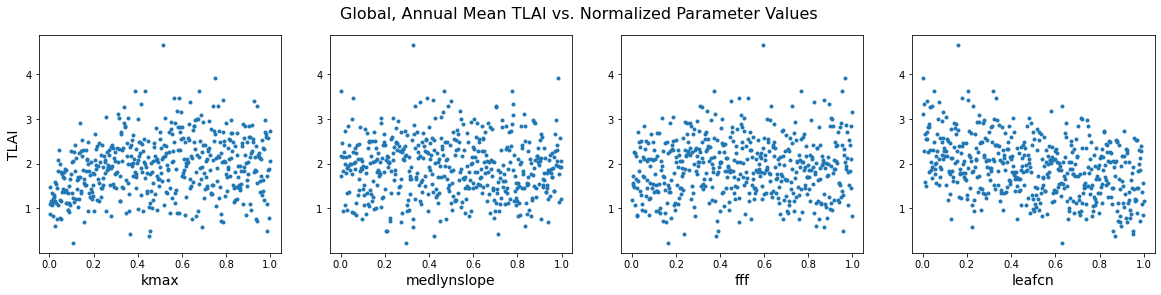

In [39]:
# plot some familiar parameters
params = ['kmax', 'medlynslope', 'fff', 'leafcn']
nparam = len(params)

# use global, annual mean TLAI
data = ds['TLAI'].sel(ens=slice(1,len(ds.ens)),biome='Global').mean(dim='year')

fig, axs = plt.subplots(nrows=1, ncols=nparam, figsize=(20,4))

for i,p in enumerate(params):
    px = ppe_params[p]
    axs[i].plot(px, data, '.')
    axs[i].set_xlabel(p, fontsize=14)
    if i==0:
        axs[i].set_ylabel('TLAI', fontsize=14);

fig.suptitle('Global, Annual Mean TLAI vs. Normalized Parameter Values', fontsize=16);

## Load the full CLM PPE dataset instead of the reduced data version
It is helpful to use this version when you want more spatial and temporal information (instead of spatial and annual means in the reduced version).

### Use Dask workers to help with larger dataset size

In [44]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    project='UVIR0010', # Input your project ID here - using the data analysis allocation project number from sam.ucar.edu
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Use the dashboard link to monitor dask worker cpu/memory usage

In [45]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:43900,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data using functions from the CLM PPE analysis code

In [46]:
# dvs are the data variables, yy are the years to sample
ds_full = get_exp('transient', dvs=['TLAI'], yy=(2005,2014))

In [47]:
ds_full

<xarray.Dataset>
Dimensions:              (gridcell: 400, ens: 501, time: 120, lon: 144, lat: 96, landunit: 1267, column: 2974, pft: 8574, param: 32, biome_id: 10, pft_id: 17)
Coordinates:
  * gridcell             (gridcell) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * time                 (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:...
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * biome_id             (biome_id) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: ens, landunit, column, pft, param, pft_id
Data variables: (12/90)
    TLAI                 (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    area                 (lat, lon) float32 ...
    landfrac             (lat, lon) float32 ...
    landmask             (lat, lon) float64 ...
    pftmask              (lat, lon) float64 ...
    nbedrock             (lat, lon) float64 ...
    ...                   ...
    PREC                 (time, gridcell) float32 dask.array<chunksize=(60, 400), meta=np.ndarray>
    VPD                  (time, gridcell) float32 0.2293 0.1863 ... 0.001036
    VP                   (time, gridcell) float32 0.8749 0.9509 ... 0.0696
    biome                (gridcell) float64 ...
    biome_name           (biome_id) object ...
    pft_name             (pft_id) <U35 'not_vegetated' ... 'c3_irrigated'
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/28/22 23:41:58
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0000.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### Compute the annual mean for each year
Using a built-in `amean` function (see `ppe_analysis/analysis.py` for details)

In [48]:
da_amean = amean(ds_full['TLAI'])
da_amean

<xarray.DataArray 'TLAI' (year: 10, ens: 501, gridcell: 400)>
array([[[3.57170194, 2.73518482, 5.51871788, ..., 0.        ,
         0.        , 0.        ],
        [3.51115591, 2.65940901, 5.7322543 , ..., 0.        ,
         0.        , 0.        ],
        [2.4255527 , 1.55851427, 5.17176848, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [4.48345582, 4.04625786, 4.30000013, ..., 0.        ,
         0.        , 0.        ],
        [3.55916292, 2.6680534 , 6.20653604, ..., 0.        ,
         0.        , 0.        ],
        [2.81620673, 1.7668468 , 5.27009507, ..., 0.        ,
         0.        , 0.        ]],

       [[3.59275344, 2.93756002, 5.49826853, ..., 0.        ,
         0.        , 0.        ],
        [3.52833677, 2.86695874, 5.73048455, ..., 0.        ,
         0.        , 0.        ],
        [2.44854602, 1.72521465, 5.13254761, ..., 0.        ,
         0.        , 0.        ],
...
        [3.99303907, 2.88083689, 3.96085487, ..., 0.        ,
         0.        , 0.        ],
        [3.3843423 , 1.80879556, 5.72121935, ..., 0.        ,
         0.        , 0.        ],
        [2.61176053, 1.12723441, 5.09750097, ..., 0.        ,
         0.        , 0.        ]],

       [[3.35646614, 1.93762395, 5.35473118, ..., 0.        ,
         0.        , 0.        ],
        [3.12944774, 1.95515408, 5.56893958, ..., 0.        ,
         0.        , 0.        ],
        [2.20777381, 1.00615078, 4.89635395, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [4.07363522, 2.99559577, 4.3631019 , ..., 0.        ,
         0.        , 0.        ],
        [3.33447953, 1.89120423, 6.0393448 , ..., 0.        ,
         0.        , 0.        ],
        [2.52041074, 1.19556735, 5.10186932, ..., 0.        ,
         0.        , 0.        ]]])
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * year      (year) int64 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
Dimensions without coordinates: ens

### Use a built-in mapping function `get_map` to translate from the sparse grid to global grid
Use the first ensemble member and last year to demonstrate

In [51]:
da_amean_map = get_map(da_amean.sel(ens=0, year=2014))
da_amean_map

<xarray.DataArray 'TLAI' (lat: 96, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    gridcell  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    year      int64 2014
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0

### Plot the map

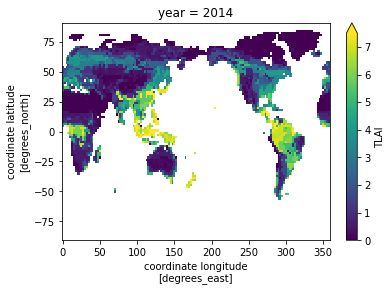

In [52]:
da_amean_map.plot(robust=True);

### Compute the global mean for each year
la = land area, which is needed for the spatial mean calculation in `gmean`

In [55]:
da_gmean = gmean(da_amean,ds_full.la)
da_gmean

<xarray.DataArray 'TLAI' (ens: 501, year: 10)>
array([[2.03945549, 2.09127127, 2.10705906, ..., 2.14533091, 2.12604864,
        2.17125251],
       [2.3572954 , 2.43847676, 2.48284272, ..., 2.5216033 , 2.51154556,
        2.53445729],
       [2.02260148, 2.04824091, 2.09447223, ..., 2.12247067, 2.10435655,
        2.14468239],
       ...,
       [1.65628067, 1.69185549, 1.70809745, ..., 1.76434987, 1.73860773,
        1.78376114],
       [1.73813916, 1.76327354, 1.77736657, ..., 1.81606774, 1.80955239,
        1.82979845],
       [1.87883046, 1.9269403 , 1.96926262, ..., 2.00564898, 2.00529722,
        2.0152095 ]])
Coordinates:
    group    <U6 'global'
  * year     (year) int64 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
Dimensions without coordinates: ens

### Plot a timeseries

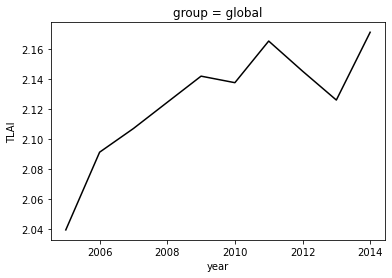

In [56]:
da_gmean.sel(ens=0).plot(color='k');

This is the same as the reduced data timeseries above, but only for the last 10 years (2005-2014).

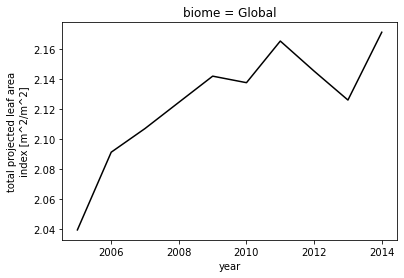

In [57]:
# verify it matches
ds['TLAI'].sel(ens=0, biome='Global', year=slice(2005,2014)).plot(color='k');

### Compute the mean over years

In [58]:
da_mean = da_gmean.mean(dim='year')
da_mean

<xarray.DataArray 'TLAI' (ens: 501)>
array([2.12499376, 2.48840346, 2.09403108, 3.7635661 , 2.33198819,
       1.33763841, 3.62331726, 2.45387822, 2.48622131, 1.50813409,
       3.28051303, 2.05272098, 2.61377016, 1.84531818, 1.37110234,
       2.28454239, 2.71349716, 2.14208939, 0.76505578, 2.14261052,
       2.91407408, 2.528695  , 1.55570808, 1.18833714, 2.55481322,
       1.99008855, 1.28182393, 1.90478205, 3.76568934, 4.15924302,
       2.29892078, 0.89011972, 1.83169575, 1.80102996, 1.9617374 ,
       2.06860602, 2.72726857, 3.0127438 , 2.49591354, 3.02558462,
       3.50672844, 2.45811322, 2.78484095, 2.42584301, 1.04256859,
       2.4367215 , 2.67446534, 3.06484994, 2.65896292, 2.47996008,
       2.51465908, 2.55843862, 3.28818815, 1.75861204, 2.40491969,
       1.42929715, 1.85494036, 3.40464054, 3.9113808 , 2.59453289,
       2.4638924 , 2.97107676, 4.32407484, 2.10917762, 2.54473165,
       1.67556585, 1.43938071, 0.48438188, 3.41342428, 1.72522837,
       1.03317429, 1.41725704, 1.82300662, 2.07004743, 1.38199548,
       2.19635977, 3.1092833 , 1.73033841, 2.91784343, 3.53673315,
       3.51334067, 3.28153256, 2.18916288, 1.13724616, 1.95993753,
       3.29714943, 1.78568611, 2.06441801, 2.17216131, 2.27659225,
       2.28345328, 1.99220828, 3.25201858, 1.71819514, 1.42047399,
       1.91575024, 2.10269365, 1.89541426, 2.58593196, 1.04865527,
...
       2.68729407, 3.43171505, 1.8106788 , 2.88120571, 2.32758524,
       1.99188325, 2.04149283, 2.99749926, 3.17618346, 2.47546527,
       4.05717179, 2.66626604, 2.79145901, 3.07081759, 1.5378024 ,
       2.04420907, 3.20476562, 2.36389681, 2.47414983, 1.65079109,
       2.15897402, 2.26710064, 2.58846434, 3.35513422, 2.07105126,
       2.09100012, 1.32146187, 2.19661589, 2.32506476, 1.05345072,
       1.55395835, 1.17861185, 1.57732885, 1.62958121, 3.43299241,
       2.29514954, 3.08345726, 2.76805986, 3.12303793, 2.10443786,
       3.0321001 , 1.08937415, 2.20741905, 3.40158118, 2.7230044 ,
       1.63691076, 2.59016237, 2.37358646, 2.09830878, 2.77887931,
       2.48734663, 0.34732869, 2.80858157, 1.13890828, 3.22704851,
       1.39078253, 1.43496554, 2.76220505, 1.4972727 , 1.2209213 ,
       1.20018828, 2.22131596, 1.5172692 , 2.44778231, 2.45117121,
       1.30921987, 2.94551683, 2.89295226, 4.11320486, 2.83114659,
       2.48436566, 2.2397659 , 2.42682681, 2.53555752, 2.55638167,
       3.00382502, 2.90654821, 3.04995373, 2.27066043, 2.98434448,
       2.74784604, 1.62666866, 1.59073375, 2.80667778, 2.72820588,
       2.90366298, 1.26989533, 2.76392061, 1.82552457, 2.43320664,
       1.59281692, 1.60451041, 1.05404858, 1.73526726, 1.79285669,
       1.97762295])
Coordinates:
    group    <U6 'global'
Dimensions without coordinates: ens

### Plot a histogram of annual, global mean values

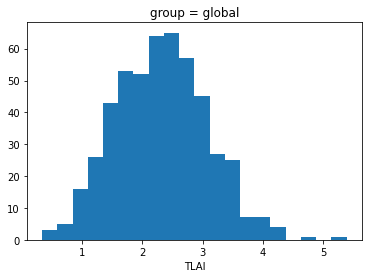

In [61]:
da_mean.plot.hist(bins=20);

Again this matches what we computed with the reduced dataset for the last 10 years

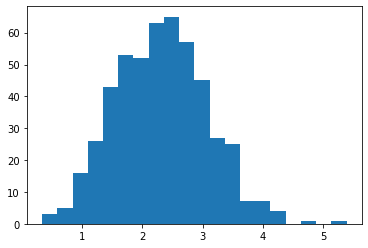

In [62]:
plt.hist(ds['TLAI'].sel(ens=slice(1,len(ds.ens)), biome='Global', year=slice(2005,2014)).mean(dim='year'), bins=20);

### Compute the climatological monthly mean seasonal cycle
First compute the global mean, then use [xr.groupby](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html) to group the timeseries by month and take the mean.

In [67]:
da_climo = gmean(ds_full['TLAI'],ds_full.la).groupby('time.month').mean(dim='time')
da_climo

<xarray.DataArray 'TLAI' (ens: 501, month: 12)>
array([[1.94610385, 1.87300433, 1.84502899, ..., 2.10703139, 2.11695789,
        2.07717746],
       [2.32894271, 2.2517425 , 2.22197245, ..., 2.44890577, 2.46362034,
        2.44101291],
       [1.9074296 , 1.85405031, 1.81835747, ..., 2.0469386 , 2.04720111,
        1.99915225],
       ...,
       [1.5835584 , 1.52415646, 1.49960777, ..., 1.70202616, 1.74616303,
        1.70618235],
       [1.63727827, 1.58188206, 1.55629385, ..., 1.76436509, 1.78962144,
        1.74397115],
       [1.8335417 , 1.77546295, 1.74300025, ..., 1.93081178, 1.93149176,
        1.92038173]])
Coordinates:
    group    <U6 'global'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: ens

### Plot the seasonal cycle across ensemble members

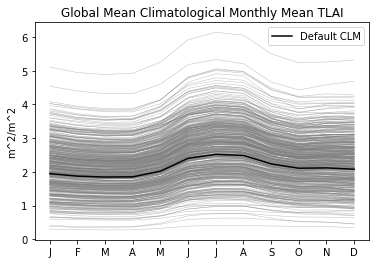

In [76]:
# create monthly time indices
tm = np.linspace(1,12,12)
mons = ['J','F','M','A','M','J','J','A','S','O','N','D']

# add the ensemble members
for i in range(len(ds.ens)-1):
    # ensemble members 1-500 (skipping default member 0)
    var = da_climo.sel(ens=i+1)
    plt.plot(tm, var, color='grey', linewidth=0.5, alpha=0.5)

# plot the default as a black line
plt.plot(tm, da_climo.sel(ens=0), color='k', label='Default CLM') 
plt.xticks(tm, mons)
plt.ylabel(ds_full['TLAI'].units)
plt.title('Global Mean Climatological Monthly Mean TLAI');
plt.legend(); 